In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
# from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats
# from statsmodels.formula.api import ols
# %matplotlib inline

Export data from R:
```
library(ISLR2)
write.csv(Boston, "boston.csv", row.names=F)
```

In [2]:
# 3.6.2 - simple linear regression
boston = pd.read_csv('../data/boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


R - fit a linear regression: 
```
attach(Boston)
lm.fit = lm(medv ~ lstat)
```

In [3]:
y = boston['medv'].to_numpy().reshape(-1, 1)
X = boston['lstat'].to_numpy().reshape(-1, 1)
sklearn_model = LinearRegression()
sklearn_model.fit(X, y)

LinearRegression()

R - showing intercept and coefficient: `lm.fit` or `coef(lm.fit)`

In [4]:
print(f'Intercept: {sklearn_model.intercept_}, Coefficeint (lstat): {sklearn_model.coef_}')

Intercept: [34.55384088], Coefficeint (lstat): [[-0.95004935]]


To get a more equivilent report to R's `summary(lm.fit)`, use `statsmodels`.
There exists no R type regression summary report in sklearn. The main reason is 
that sklearn is used for predictive modelling / machine learning and the evaluation 
criteria are based on performance on previously unseen data (such as predictive r^2 
for regression).

More info: https://datatofish.com/statsmodels-linear-regression/

In [5]:
sm_X = sm.add_constant(X)
sm_model = sm.OLS(y, sm_X).fit()
predictions = sm_model.predict(sm_X) 
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           5.08e-88
Time:                        15:35:46   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.000      33.448      35.659
x1            -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# R summary comparison
Data in both summaries:
- Coefficients match Python
- Multiple R-squared is R-squared in Python
- Adjusted R-squard is Adj. R-squared in Python
- F-statistic is F-statistic in Python
    - the "1 and 504 DF" can be found in DF Model and DF Residuals in Python
- p-value is likely under the P>|t| section, but so small it's showing 0 instead of 2.2e-16 in Python

Data missing from Python:
- Residuals (Min, 1Q, Median, 3Q, Max)
- Residual standard error (504 is listed, but not 6.216)
- Signif. codes

```
Residuals:
    Min      1Q  Median      3Q     Max 
-15.168  -3.990  -1.318   2.034  24.500 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 34.55384    0.56263   61.41   <2e-16 ***
lstat       -0.95005    0.03873  -24.53   <2e-16 ***
---
Signif. codes:  
0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.216 on 504 degrees of freedom
Multiple R-squared:  0.5441,	Adjusted R-squared:  0.5432 
F-statistic: 601.6 on 1 and 504 DF,  p-value: < 2.2e-16
```

R - obtain a confidence interval for the coefficient estimates: 
```
> confint(lm.fit)
                2.5 %     97.5 %
(Intercept) 33.448457 35.6592247
lstat       -1.026148 -0.8739505
```

In [6]:
# The default alpha = .05 returns a 95% confidence interval.
sm_model.conf_int(alpha=0.05, cols=None)

array([[33.44845704, 35.65922472],
       [-1.0261482 , -0.87395051]])

Producing confidence intervals for medv for a given value of lstat
```
> predict(lm.fit, data.frame(lstat=(c(5, 10, 15))), interval="confidence")
       fit      lwr      upr
1 29.80359 29.00741 30.59978
2 25.05335 24.47413 25.63256
3 20.30310 19.73159 20.87461
```

In [7]:
sm_model.get_prediction(sm.add_constant([5, 10, 15])).summary_frame()[['mean', 'mean_ci_lower', 'mean_ci_upper']]

,mean,mean_ci_lower,mean_ci_upper
0,29.803594,29.007412,30.599776
1,25.053347,24.474132,25.632563
2,20.303101,19.731588,20.874613


Producing prediction intervals for medv for a given value of lstat
```
> predict(lm.fit, data.frame(lstat=(c(5, 10, 15))), interval="prediction")
       fit       lwr      upr
1 29.80359 17.565675 42.04151
2 25.05335 12.827626 37.27907
3 20.30310  8.077742 32.52846
```

In [8]:
sm_model.get_prediction(sm.add_constant([5, 10, 15])).summary_frame()[['mean', 'obs_ci_lower', 'obs_ci_upper']]

,mean,obs_ci_lower,obs_ci_upper
0,29.803594,17.565675,42.041513
1,25.053347,12.827626,37.279068
2,20.303101,8.077742,32.528459


Plot along with least squares regression
```
plot(lstat, medv)
abline(lm.fit)
```
![regression](images/least_square_regression.png)

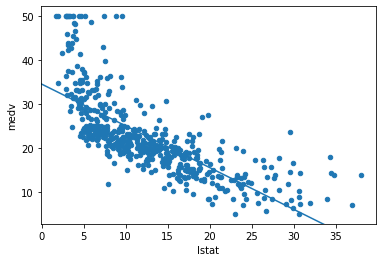

In [16]:
ax = boston.plot.scatter(x='lstat', y='medv')
abline_plot(model_results=sm_model, ax=ax)
plt.show()

Split screen into separate panels
```
par(mfrow=c(2, 2))
plot(lm.fit)
```
![grid plot](images/2_2_grid_plot.png)

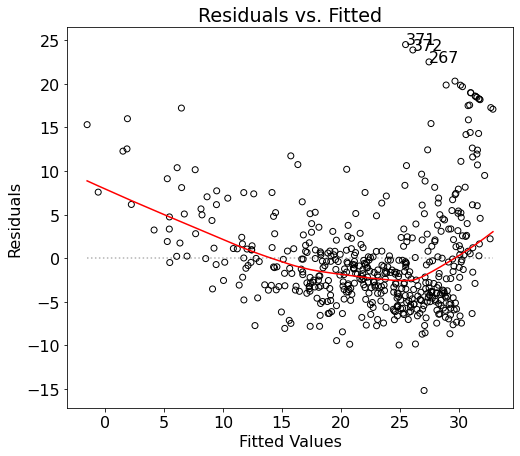

In [76]:
# https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a
# note the R notation in formula.api.ols
def residuals_vs_fitted(results):
    residuals = results.resid
    fitted = results.fittedvalues
    smoothed = lowess(residuals, fitted)
    top3 = abs(residuals).sort_values(ascending = False)[:3]

    plt.rcParams.update({'font.size': 16})
    plt.rcParams["figure.figsize"] = (8,7)
    fig, ax = plt.subplots()
    ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Residuals vs. Fitted')
    ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

    for i in top3.index:
        ax.annotate(i,xy=(fitted[i],residuals[i]))

    plt.show()

results = smf.ols("medv ~ lstat", data=boston).fit()
residuals_vs_fitted(results)

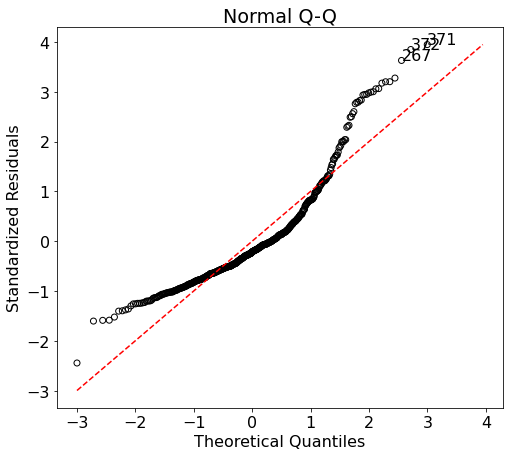

In [74]:
def normal_q_q(results):
    sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    sorted_student_residuals.index = results.resid.index
    sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
    df = pd.DataFrame(sorted_student_residuals)
    df.columns = ['sorted_student_residuals']
    df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
    rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
    top3 = rankings[:3]

    fig, ax = plt.subplots()
    x = df['theoretical_quantiles']
    y = df['sorted_student_residuals']
    ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
    ax.set_title('Normal Q-Q')
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Theoretical Quantiles')
    ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
    for val in top3.index:
        ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
    plt.show()

normal_q_q(results)

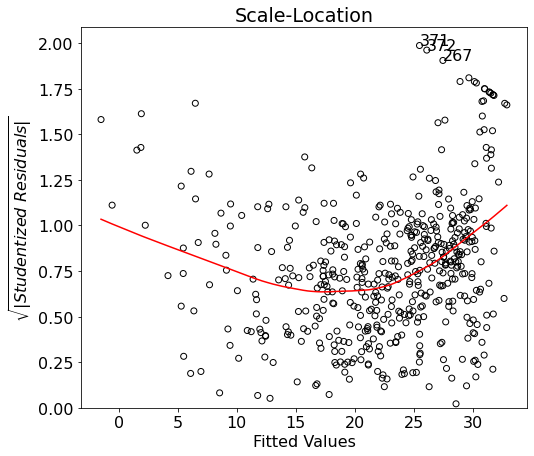

In [77]:
def scale_location(results, fitted):
    student_residuals = results.get_influence().resid_studentized_internal
    sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
    sqrt_student_residuals.index = results.resid.index
    smoothed = lowess(sqrt_student_residuals,fitted)
    top3 = abs(sqrt_student_residuals).sort_values(ascending = False)[:3]

    fig, ax = plt.subplots()
    ax.scatter(fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Scale-Location')
    ax.set_ylim(0,max(sqrt_student_residuals)+0.1)
    for i in top3.index:
        ax.annotate(i,xy=(fitted[i],sqrt_student_residuals[i]))
    plt.show()

fitted = results.fittedvalues
scale_location(results, fitted)

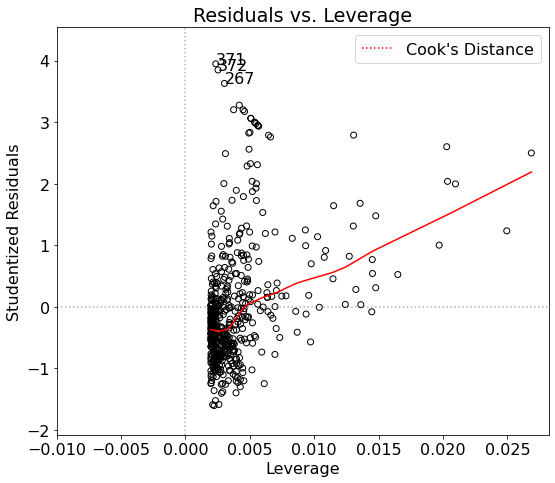

In [79]:
def residuals_vs_leverage(results):
    student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    student_residuals.index = results.resid.index
    df = pd.DataFrame(student_residuals)
    df.columns = ['student_residuals']
    df['leverage'] = results.get_influence().hat_matrix_diag
    smoothed = lowess(df['student_residuals'],df['leverage'])
    sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
    top3 = sorted_student_residuals[:3]

    fig, ax = plt.subplots()
    x = df['leverage']
    y = df['student_residuals']
    xpos = max(x)+max(x)*0.01  
    ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Studentized Residuals')
    ax.set_xlabel('Leverage')
    ax.set_title('Residuals vs. Leverage')
    ax.set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
    ax.set_xlim(-0.01,max(x)+max(x)*0.05)
    plt.tight_layout()
    for val in top3.index:
        ax.annotate(val,xy=(x.loc[val],y.loc[val]))

    cooksx = np.linspace(min(x), xpos, 50)
    p = len(results.params)
    poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
    poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
    negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
    negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

    ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
    ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
    ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
    ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
    ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
    ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
    ax.legend()
    plt.show()

residuals_vs_leverage(results)

In [ ]:
# TODO: combine functions above into a single function, save as python module to import for future use

Plot residuals: `plot(predict(lm.fit), residuals(lm.fit))`

In [ ]:
# looks like residuals_vs_fitted() minus smoothed red line


Plot residuals: `plot(predict(lm.fit), rstudent(lm.fit))`

In [ ]:
# looks like scale_location() minus smoothed red line


Plot leverage stats: `plot(hatvalues(lm.fit))`

# Non-book work
Missed attempts at cloning R output that might be useful for other things

In [10]:
# borrowed function from web, doesn't apply to this chapter directly but may use elsewhere
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)  # negative error
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    # print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
y_pred = sklearn_model.predict(X)
regression_results(y, y_pred)

explained_variance:  0.5441
r2:  0.5441
MAE:  4.5053
MSE:  38.483
RMSE:  6.2035


In [11]:
# finding properties of get_prediction function for statsmodels
dir(sm_model.get_prediction())

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'conf_int',
 'df',
 'dist',
 'dist_args',
 'predicted_mean',
 'row_labels',
 'se_mean',
 'se_obs',
 'summary_frame',
 'var_pred_mean',
 'var_resid']

In [12]:
sm_model.get_prediction().conf_int()[0:10]

array([[29.02529896, 30.61989124],
       [25.2652456 , 26.47553397],
       [29.87347656, 31.57680741],
       [30.84359393, 32.67779762],
       [28.7120765 , 30.26807915],
       [28.81951546, 30.38865203],
       [22.20157281, 23.28788202],
       [15.62611418, 17.09467733],
       [ 4.69643293,  7.54129451],
       [17.66827206, 18.9477218 ]])

In [13]:
sm_model.get_prediction().summary_frame().head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,29.822595,0.405814,29.025299,30.619891,17.584603,42.060587
1,25.870390,0.308011,25.265246,26.475534,13.643413,38.097367
2,30.725142,0.433488,29.873477,31.576807,18.483488,42.966796
3,31.760696,0.466794,30.843594,32.677798,19.514315,44.007076
4,29.490078,0.395994,28.712077,30.268079,17.253328,41.726828


In [14]:
sm_model.get_prediction().se_mean[0:10]

array([0.40581435, 0.30801126, 0.43348767, 0.46679404, 0.39599351,
       0.39933602, 0.2764593 , 0.37374067, 0.72400052, 0.32561243])

eval_env: 1


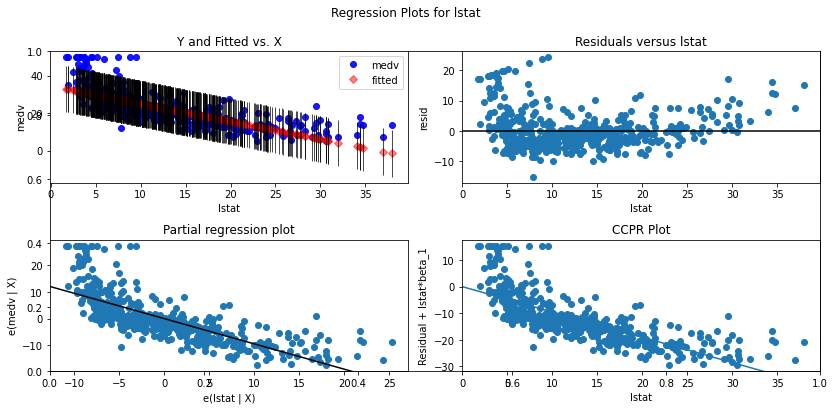

In [55]:
# early attempt at plot(lm.fit) from R
fig, ax = plt.subplots(figsize=(12, 6))
fig = sm.graphics.plot_regress_exog(ols_model, 'lstat', fig=fig)
fig.tight_layout(pad=1.0)